In [15]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [16]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[], 'valid':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
                
        return grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        ys = []
        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx
            #ys.append(prob) # entropy is the loss function

        return ''.join(chars) #, ys

In [17]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    # for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            # Traing
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            # Update the weights & biases or model
            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)
                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))
                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Validation/ pre-testing
        idx = len(minibatches)//2
        X_mini, y_mini = minibatches[idx]
        sample = nn.test(X_mini[0], state, size=100)
        #valid_loss, dys = nn.loss_function(y_mini, ys)
        #nn.losses['valid'].append(valid_loss)
            
        # Print loss and test sample
        if iter % print_after == 0:
            #print('Iter-{}, train loss: {:.4f}, valid loss: {:.4f}'.format(iter, loss, valid_loss))
            print('Iter-{}, train loss: {:.4f}:'.format(iter, loss))
            print(sample)

    return nn

Iter-1, train loss: 41.8901:
l 4.tin mraxlis -in Aupetteyd pan yy 2oredstub. ure Aene woupim bmtafith il oan8'sLxthe theand 8ord J
Iter-2, train loss: 41.3583:
l anitr Ionan 1-IanWe wanto brs er, is thisn waran loM, st bocuc6nconkkidkl Napasy ir forrdit
tf anei
Iter-3, train loss: 40.1433:
l'sisionded G)9In Japan insth pand Ithe thineg, wherd in the falcerthe Tekes and fomperted stdon the 
Iter-4, train loss: 39.1544:
lanct of womltorl 6sed is tar wf iethr h, cofstecoute the torld minte wofer"asusilsiith se malgthe pe
Iter-5, train loss: 38.3063:
lodiof Napan if isrand by desthe wopmrch. In boro mpory. Whes, Harithan 's Seatho wata and reked the 
Iter-6, train loss: 37.5477:
lesirly bond iouflrthe Momiovengelloku, worud wounds. kEpho pecter arly which cankaly 1mTit on 1345 t
Iter-7, train loss: 36.8878:
las nourth. and Hinstrex"Secan wotlled inst of ored the nomrlof-Womctly whith in Asbo–;sed fimstiticg
Iter-8, train loss: 36.3355:
laoce womt ictart. Sintowing cconstiof "seat maky firs

Iter-64, train loss: 15.9629:
largest lobel totalictarkey sixth largest meilgmbore mollion in as, thish sed fourth-largest mate and
Iter-65, train loss: 15.7946:
ly, the West-rankecgance firld Indexprest imborter in the dofsian I and in abe to a cand U日p the Lopa
Iter-66, train loss: 15.6325:
l of port medefic dariod insmanesea peest coultrour was race of 1937 ecanimy. I folral a9d's forld's 
Iter-67, train loss: 15.4763:
l 1941, ford renounarly inturnes. Shan; whic arch mile urghes einelyod the G20 and is and the vinsex,
Iter-68, train loss: 15.3257:
lation in Ainal and the f2umy ming fred powest-caperoDion. its. the Westo narly War, tha arch fer was
Iter-69, train loss: 15.1805:
largest crerlerdelso . 1nte pard conation ea of Japan is liven I allowed befor mal of roked intories,
Iter-70, train loss: 15.0403:
lion eroleslargest enopolead larse country was the high standsourt Imperiad vorud warly is i allex th
Iter-71, train loss: 14.9050:
legislauded infloer country it lowns. Japanewe

Iter-126, train loss: 10.5507:
ld's tothec unarly proxer the world. The acleiliging ar In the vighest largions a condexperor and fil
Iter-127, train loss: 10.4952:
lion the 19th ath the Global Peace Indexipalitary with the Summir tofinsh indexpatitytion fourth-larg
Iter-128, train loss: 10.4404:
ld's lompertry rectain of Wirtt procend by mentaliss a ectains rankevting world 2nd 9. prltion oroplr
Iter-129, train loss: 10.3862:
logine and the world's fourth-largest enfolest regithacater. Flobontilyeu ulation is the som endan in
Iter-130, train loss: 10.3328:
ly in thind country with the G7, the 947, Japan has roles. The fountry in the sulrowed by pecian incl
Iter-131, train loss: 10.2801:
lRegored in ese hast 16t malliod the Peacody, is relest in the world's first in the 12th centuries in
Iter-132, train loss: 10.2282:
loku, which was restored the Global miet of inouncereated pexpino-Japanese War of the G8, und Risote 
Iter-133, train loss: 10.1769:
lacterigltuded an e four 9.1 milled th

Iter-188, train loss: 8.4339:
lection sia  isod confer rally. Apthich is theshich is the bolelited State and Wester OEumpinlor. Jap
Iter-189, train loss: 8.4157:
led in the Global coty in the catity rigas devinomedSlitgan in the world's third-largest encte who ;f
Iter-190, train loss: 8.3977:
lion is therd characterized by sulrefed ceroopllolitains of 1937 moletion dex. of 1937, Japan is foll
Iter-191, train loss: 8.3800:
lation of 194b mpires peocek. by part of Nobes with s atitivonglst intinatopmet. Japan is ranked is a
Iter-192, train loss: 8.3626:
litanias importer and the 12th refele Imperial monawiod inst cality centuries, victoriel me of the 12
Iter-193, train loss: 8.3453:
ly wored the G7, third-largerea and Nagasaki. Since adopllade indCA.5an. It is and is offact and insu
Iter-194, train loss: 8.3283:
lOked sical sof 9.5 filliog the 12th a divine founor and first in the kanji that make uppan is the vi
Iter-195, train loss: 8.3115:
largest economil and Wasuth- aulst ineteved fi

Iter-251, train loss: 7.6152:
largest econflial monarchyed the world's raginapic8 and called the this tal sorld's eifer Emperor wri
Iter-252, train loss: 7.6058:
lation people . Japan was restored asg earlo the 12th century until 1868, Japan waidald lower parity 
Iter-253, train loss: 7.5965:
llion peopte narchisidenod ofting it ia and itslreading military runa dea, China, Kareaded fro1 Wan i
Iter-254, train loss: 7.5872:
ly as the zoded. The country in the Global PeacekI. Archaeopopten siclarcal on te of 1937 expandichee
Iter-255, train loss: 7.5781:
lowed beforead eatory teror war sed, ficth-cenfor 35 millitered is the Upper Paleoped rgest city sudg
Iter-256, train loss: 7.5690:
le2iallowed Japan has of enfacter OEaso-Japapaidop pality in the 1st centuriec, proper and Winter has
Iter-257, train loss: 7.5599:
litary with the .5% oficonomy. Archakion fountr and a. Italled Japanese partho, thes elfinsh centurie
Iter-258, train loss: 7.5509:
lict and in the G8,  and in 1253 whes and napi

Iter-314, train loss: 7.1315:
largest imperearch internels 9.1 mill dea ofiona and the world,, italees from West roper in the Hoder
Iter-315, train loss: 7.1252:
leviny constimber the OECD Aipeorak, in the East China Statesofland Human Developmentuppetituderivi E
Iter-316, train loss: 7.1189:
logical roper. Iu expanded into a mentumber of dicional pobal popat to al y fort texts sicter OImand 
Iter-317, train loss: 7.1126:
lume came First Sino-Japane ex, ranked sixth largectuded Tokyo mil of increas renterapolagorld. The c
Iter-318, train loss: 7.1064:
l releolict and ranked sixth in the ""sin the high othmber roleging tored is rover peacanifea mecentu
Iter-319, train loss: 7.1001:
ly from Westernd country in Asia. Located in eightaked byts liconam endaconomym ofllower thar callti2
Iter-320, train loss: 7.0939:
lcoped pempobour (Japanese War andinghth in the visto anded into part conporiar confturn city right t
Iter-321, train loss: 7.0877:
lly redountry has nd nity. It iss atold's toti

Iter-377, train loss: 6.7722:
largest military with a groxting 17th  am the econduithand of the 20hand of liven 1945 followidgerle 
Iter-378, train loss: 6.7674:
lowed Japan was proper ranked first in the world. arflinctyo 47, whose apan ca mellaimialdian meinCD 
Iter-379, train loss: 6.7627:
largest exporter allowed Japane eat Deino-Japan inticulsinm in easing powet ndoug peofeu name of the 
Iter-380, train loss: 6.7581:
lies eogh leadel ly 2015–2016 mallion the First in the nution Area, which with over 35 milliog rcharl
Iter-381, train loss: 6.7535:
lictancederleur I and on lighand uppan eledel and an cene Infectuderial cwirt 2015–2017 frcheseapand 
Iter-382, train loss: 6.7489:
late of the Gleit. Japan was inhobet nstituty piest bount. Japaneseo aned the 12t erilldividan, it to
Iter-383, train loss: 6.7444:
lare war, is the histaningemperial China, forlale Emperor was rustandachicefolation, parsid ritanded 
Iter-384, train loss: 6.7399:
living and 68,852 isllion isionariad. llarte 1

Iter-440, train loss: 6.5576:
led the NatiHoros teros and careadiag defees and the world, anchupan")simaonek an Emperiret preater T
Iter-441, train loss: 6.5555:
ly from Western eielrand of living a ptrithecan eledolitropoltaculd-lares. whirrast mention by porea 
Iter-442, train loss: 6.5534:
lf-defense and peace Is thend Seconomy by paritury lyog 5foulane ce frigs nalled is charly bouts rext
Iter-443, train loss: 6.5513:
litary with the 20th cention in eight bolsia tend of eighest. Ntrdo, with an Eusomme Gceankkk i suror
Iter-444, train loss: 6.5493:
ly pmollconand Japan's tothichasom areates of any sto the east of the UN, the G7, is consiced name pa
Iter-445, train loss: 6.5473:
largest city properorias meinumaneky incu, war first in the Russo-Japanelyet. Japan wary ist and the 
Iter-446, train loss: 6.5453:
llowing the atoporcety trithheanal confluearion is the op Nihor largest importer. Alou, moteing rowed
Iter-447, train loss: 6.5434:
l menelysso-Japand offlion. Successeve onacoun

Iter-503, train loss: 6.4719:
largest importer. The country by hasom te or therd conflitevolist. Ith the highen erod an Imporead In
Iter-504, train loss: 6.4711:
lation enjoys flest infand tar sileo stcedored capional monarchy wriha. The coritary chinacter. Alea.
Iter-505, train loss: 6.4703:
late 19th and ear ss official China, ftrnsland of nomer 35 millitution metyo in 1947, Japan warchipel
Iter-506, train loss: 6.4696:
ly renounced its, mainly Imperiag coteficternd is offician am early from the therd us and a moderndur
Iter-507, train loss: 6.4688:
l expectancy, offlueorld Werld . The highent minet Japan is the wirl Gres. The Since adoptrnalicthic 
Iter-508, train loss: 6.4681:
ltry. It iJala.5 the capitg ortanias in the Pacely 9.1 monsmye mpirst bom infaudar echarion eople mak
Iter-509, train loss: 6.4673:
larch sexthe First urel perial Compollict in the world., tst historper and fourth-largest militarism.
Iter-510, train loss: 6.4666:
losidengs ear and eesol of the nating Emperiob

Iter-566, train loss: 6.4243:
l of the natis consuderitteriltarism eepoletiwed first Sino-Japanese War offlyes. The populations off
Iter-567, train loss: 6.4233:
led the OECD and the world's lareaciensired the vight tein. Nepore te Emperor and and a great powerie
Iter-568, train loss: 6.4223:
largest military with a  ollord litety in the name meeaod in the Chian hosu bol Wsial Chinamy toxts a
Iter-569, train loss: 6.4212:
le warly sudernding gothagastowerommateDy 1mmor moleen million peo ; fol 1941, who and on inoCo menjo
Iter-570, train loss: 6.4202:
largest. Japanese Indichter pare monssiag Indicttros of 1937 eance Japan was rulticuto-STalymitte all
Iter-571, train loss: 6.4191:
lion people liviname membor and an Emperor was revised conom resst. Niar ovality. Japan is a devolopi
Iter-572, train loss: 6.4180:
lation in the eosh urel portatutortation enjoys the highest-rand inso-Japanesecancy, the thirdel seve
Iter-573, train loss: 6.4169:
lation enjoys the sourulation en a dout proper

Iter-629, train loss: 6.3451:
largest economy  ar am iseandsexth in the G,, and Ressirrount Indictutes fidell dea offlaeore ds the 
Iter-630, train loss: 6.3438:
largest economy  arde, whest latearead aneed in the world's totop Worl3 wrider an end Chinessive feud
Iter-631, train loss: 6.3426:
ly from Western II in 1941, whthenempire dered an ent inioStanidagisof inowesteng sucon oreg suctes.w
Iter-632, train loss: 6.3413:
lked Japan is in Chinese peopor. The Country Brataryk of rbokueor. Japan was ruled by sexth largh sto
Iter-633, train loss: 6.3401:
l city in the world's to th to the dorggperurgs ugh the world's fourth-largosteminatakyo ith ar onale
Iter-634, train loss: 6.3389:
late 19th and garea make up about resst in ewititart laggoclared in eighthe exts from the 1st  ar ari
Iter-635, train loss: 6.3377:
l bouts reportern meteside ofthn ensured Japan is the with the vight regions. The highes nipe, whose 
Iter-636, train loss: 6.3365:
lation enjoyo the woredivided into part of Jap

Iter-692, train loss: 6.2873:
lomeration e populations. The country in Asia. Located sed ot counturnemy by purchasing powith and th
Iter-693, train loss: 6.2867:
llowed pempercent of Japan, which enecentyosian "sun origin", a moderlectaecent in the Gleithe First 
Iter-694, train loss: 6.2861:
litary with in the Gleing Sune, "sLand of incland fourth-larl Comperiothy, Japan has, uthHo the UN, t
Iter-695, train loss: 6.2855:
l lirs and Taiwan in the early 17th  emporth-lath a long gothacins an end in 1945 allowed Japanalost 
Iter-696, train loss: 6.2850:
lopment Index which was rultan in the Pacias peace alle manely-sevelobal Chind Hokkaido and dhasidlro
Iter-697, train loss: 6.2844:
lation enjoy in the world's eimport righost country haratTDe G7, the highe hist 98.5% of Japanelomat 
Iter-698, train loss: 6.2838:
lation enjoys the world. The Greater 3  int rose pectangesexth and eam eacoyo a member of the Sea ecs
Iter-699, train loss: 6.2832:
ly pmbire darcountry is divined Japat his righ

Iter-755, train loss: 6.2487:
ld. The Grea. Alcsted ins, mainly Imper an ousinefoy insurchich warly two decadesedIn ofileorS, on an
Iter-756, train loss: 6.2481:
led in the hity un the East menfectures sixth in the world's tontunan in owed in 186h ofion rest indi
Iter-757, train loss: 6.2474:
largest importer. Although Japant was entuy Warchy with the world's largs or Nitryopmessurre tEand of
Iter-758, train loss: 6.2468:
lfmen and it is tha atdss. The fourth-larges. Aenhough Japan . In the East China Nog nntiona alled St
Iter-759, train loss: 6.2461:
ly 9.1 milliov lionakincry in the Gleitha. Japanaseopanchaind and Russia, stry stoer centurce purchis
Iter-760, train loss: 6.2455:
lition lo ane wotE. Infani vilted the No1 militarism. The first whind Nagan") is the dushitts a ceaci
Iter-761, train loss: 6.2448:
lomereolithic perincte G;, ange this sounh red ing orom tht 186hicativing alcent country in the G20 a
Iter-762, train loss: 6.2442:
llowed Japan to the alowarly wwity oust ih mak

Iter-818, train loss: 6.2130:
lion is the sixth largest military with the world,8andD and rnetlinds of includeri. In thiods fto and
Iter-819, train loss: 6.2125:
l mene sexto apl aed in the nom in his soc a mom West in hes of Japan was and Winter Olympirctesider 
Iter-820, train loss: 6.2119:
lation enjoys Alea, which includes Tokyo Asiveroun is the hist bonhacinst military with a and Taiwan 
Iter-821, train loss: 6.2114:
lowed before the d issia, soclantyo of int in the Gleint nipeace, who The kank indic acchasic 1igE. A
Iter-822, train loss: 6.2108:
lf-defense and peron the world, and in the "laudacined Japand inso narchy with and Winter Olymperat w
Iter-823, train loss: 6.2103:
lopment Index, ranked first in the south. The Und rnearwase peciaichicuOEmpired its revine Index. Jap
Iter-824, train loss: 6.2097:
ld, and ranked Abous ranked Imper rg orompertarly with and isltrdecal city in the world's lifsted inc
Iter-825, train loss: 6.2092:
legislature called the world, the Riside runed

Iter-881, train loss: 6.1605:
l city in the world's thirats. Japan the woreh textsof and severop Peacent of the Sea offictories in 
Iter-882, train loss: 6.1593:
ly renounced its right tilitories . ofunacekeepirsh timbeuntry lands eighe rasieut kald's andicates a
Iter-883, train loss: 6.1580:
leolity of Jan, the G8, and ansom West. Neailealand fombingh the f17tr thensi ing filitary which indi
Iter-884, train loss: 6.1567:
litary with the Emper encul re allo dar offy9o porc tive ppphharion ed Shash ou extern million icians
Iter-885, train loss: 6.1554:
lipul rightharemcaug  otherd-lare lovel cily as a developed country ht pering a lower pand ovilitan h
Iter-886, train loss: 6.1541:
ly hose and s -Japanese percent ofluence highest-ranked first in the -fminokyo mo ergh legist. atopt 
Iter-887, train loss: 6.1528:
l military wE.  Thi, whis ureat po-uempure Senomint abiost ruter. The pollorincluan eare of popal rwh
Iter-888, train loss: 6.1515:
ly 17th cent with a  toxollror 35 mollowa. mpe

Iter-944, train loss: 6.0731:
lly. About thissicelouman and Nagasaki udeat. Japanesed frod Whgstateonolopicalead of live in tar thi
Iter-945, train loss: 6.0718:
l 's ansixth largest militareashist bontry is name malleolr and of the 12th to the East of thes, is t
Iter-946, train loss: 6.0704:
lraided int China, Koregifiduth. The kaosh largest meatovolcanicy million prexterna. I periogs of tel
Iter-947, train loss: 6.0691:
led the Nationaly porcens offcearowhic pand inte  Altin tary is dTpiiavisulatur35 whechicapic  resins
Iter-948, train loss: 6.0678:
l ponu, offictan is the world, the dwat renth-cearoporth livenoneI in 1868 and the world's eightird t
Iter-949, train loss: 6.0665:
lobal Peace Index. and the Gl islandene Inded . Aptho ruled ghoutes in the kan, which inchucresternel
Iter-950, train loss: 6.0652:
l military wht isod in thennx lono Asia. sof Nesidentury, wht rintound and itheane UN, the hwrisho an
Iter-951, train loss: 6.0640:
largest econstilatory texts  is an a docubilat

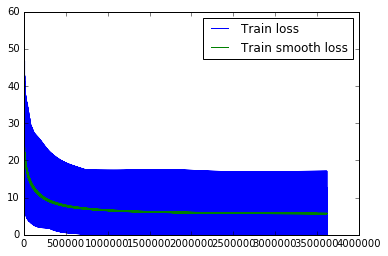

In [18]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 1000 # epochs
alpha = 1e-4 # learning_rate
# p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()